In [1]:
!pip install prince --quiet

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prince
import scipy.stats as stats
import seaborn as sns

from sklearn import tree
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 500)
sns.set_theme(context='paper', style='darkgrid', palette='colorblind',)

path = 'https://github.com/vladoxNCL/my_datasets/raw/main/WBL_1971_2023_Dataset_WORL_BANK_WOMENS_LAW.xlsx'
j_path = 'https://github.com/vladoxNCL/my_datasets/raw/main/We-Data---Historical-dataset.xlsx'
data = pd.read_excel(path, sheet_name='WBL Panel 2023')
rng = np.random.default_rng(42)
seed = rng.integers(123456)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.9/414.9 kB 2.7 MB/s eta 0:00:00


In [ ]:
df = data.copy()

new_cols = [
  'Economy', 'Economy Code', 'ISO Code', 'Region', 'Income', 'Year',
  'WBL INDEX', 'MOBILITY', 'mob_choose_home', 'mob_travel', 'mob_passport', 'mob_abroad',
  'WORKPLACE', 'work_get_job', 'work_law_discrimination', 'work_law_sexual',
  'work_law_civil_or_penal', 'PAY', 'pay_law_equal_wage', 'pay_work_night',
  'pay_work_dangerous', 'pay_industrial', 'MARRIAGE', 'marriage_no_obey',
  'marriage_head_household', 'marriage_law_domestic_violence', 'marriage_law_divorce',
  'marriage_remarry', 'PARENTHOOD', 'parent_leave_14', 'parent_leave_mother',
  'parent_gov_benefits', 'parent_father_leave', 'parent_leave_father',
  'parent_paid_leave', 'parent_shared', 'parent_days_mother', 'parent_days_father',
  'parent_law_pregnant', 'ENTREPRENEURSHIP', 'entre_credit_disc', 'entre_contract',
  'entre_business', 'entre_bank', 'ASSETS', 'assets_owner', 'assets_inherit',
  'assets_spouse_inherit', 'assets_admin', 'assets_non_monetary', 'PENSION',
  'pension_age_full_same', 'pension_age_partial_same', 'pension_retirement_same',
  'pension_childcare',
]
df.columns = new_cols

regions_replace = {
  'High income: OECD': 'High Income: OECD',
}
df = df.replace({'Region': regions_replace})

to_drop = [
    'Economy Code', 'ISO Code', 'WBL INDEX', 'MOBILITY',
    'WORKPLACE', 'PAY', 'MARRIAGE', 'PARENTHOOD', 'ENTREPRENEURSHIP',
    'ASSETS', 'PENSION',
]

df_agg = pd.concat([df['Economy'], df[to_drop]], axis=1)
df = df.drop(to_drop, axis=1)

df.loc[df['Economy'] == 'Korea, Rep.', 'Region'] = 'East Asia & Pacific'
df.loc[df['Economy'] == 'Japan', 'Region'] = 'East Asia & Pacific'
df.loc[df['Economy'] == 'Chile', 'Region'] = 'Latin America & Caribbean'

df = df.replace({'Income': {'Not classified': 'Lower middle income'}})
income_replace_d = {
    'Low income': 0,
    'Lower middle income': 1,
    'Upper middle income': 2,
    'High income': 3,
}
df = df.replace({'Income': income_replace_d})
df = df.replace({'No': 0, 'Yes': 1})

df_agg['Income'] = df['Income']

In [ ]:
X_df = df.iloc[:, 3:]
X = X_df.to_numpy()
y = df['Income'].to_numpy()

# Lists to store results
scores, imps = [], []

# 10-Fold Cross Validation
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    rf = RandomForestClassifier(random_state=seed)
    rf.fit(X_train, y_train)

    # Scores and Importances
    scores.append(rf.score(X_test, y_test))
    imps.append(rf.feature_importances_)

scores = np.array(scores)
imps = np.array(imps)

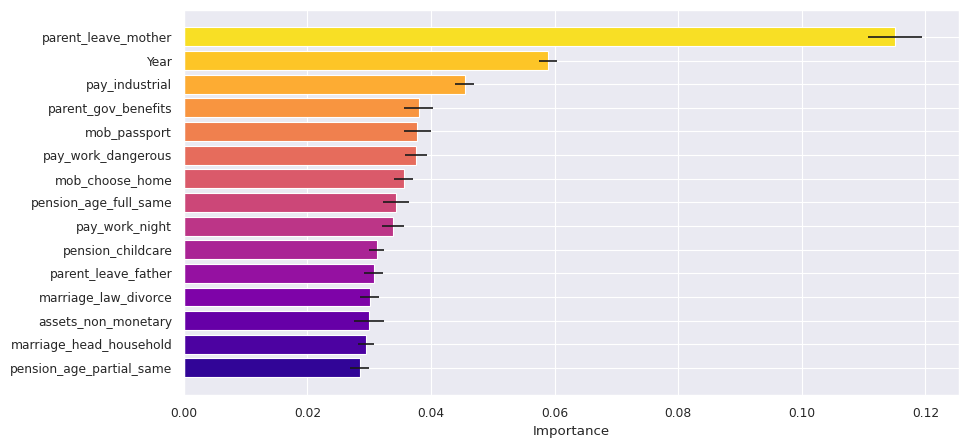

In [ ]:
# Feature Importances
mean_imps = imps.mean(axis=0)
errors = imps.std(axis=0)
imp_d = {name: {'mean': imp, 'error': std}
         for name, imp, std in zip(df.iloc[:, 3:].columns, mean_imps, errors)}
sorted_imps = sorted(imp_d.items(), key=lambda x:x[1]['mean'])

# Number of features to plot
n_imps = 15

# Subset the desired features
n_sorted = sorted_imps[-n_imps:]
feats, imp_vals, errors = zip(*[(imp[0], imp[1]['mean'], imp[1]['error']) for imp in n_sorted])

# Aesthetics: plot size, style and palette, e.g. 'plasma', 'mako' and 'viridis'
fig, ax = plt.subplots(figsize = (10, 5))
pal = sns.color_palette('plasma', n_imps)

# draw horizontal bar plot
plt.barh(feats, imp_vals, xerr=errors, color=pal)

# Change x label and title
plt.xlabel('Importance');

In [ ]:
regions = pd.get_dummies(df['Region'], prefix='region')
mdf = pd.concat([df, regions], axis=1)

mdf = (
  df
  .drop(['Income', 'Year'], axis=1)
  .groupby('Economy')
  .agg(lambda x: pd.Series.mode(x)[0])
)

reg = mdf['Region']
mdf = mdf.drop('Region', axis=1)

mca = prince.MCA()
mca = mca.fit(mdf)
mca_df = mca.transform(mdf)

m = mca.column_contributions_
m['total'] = m.sum(axis=1)
m = m.sort_values(by='total', ascending=False).head()

,0,1,total
entre_bank_0,0.011239,0.115755,0.126993
assets_owner_0,0.008608,0.089519,0.098128
assets_admin_0,0.007452,0.090137,0.097589
mob_travel_0,0.052657,0.029549,0.082206
work_get_job_0,0.041509,0.038032,0.079541


In [ ]:
for n_clusters in range(2, 6):
  kmeans = KMeans(n_clusters=n_clusters, random_state=seed, n_init='auto').fit(mca_df)
  mdf[f'Cluster_{n_clusters}'] = kmeans.labels_
mdf['Region'] = reg

In [ ]:
to_add = (
  df_agg
  .groupby('Economy')
  .agg(lambda x: pd.Series.mode(x)[0])
)

mdf_x = pd.concat([mdf, to_add], axis=1)

agg_vars = [
  'WBL INDEX', 'MOBILITY', 'WORKPLACE', 'PAY', 'MARRIAGE',
  'PARENTHOOD', 'ENTREPRENEURSHIP', 'ASSETS', 'PENSION',
]

to_melt = mdf_x.reset_index()
value_vars = ['Income', 'Region', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5']
id_vars = [c for c in to_melt if c not in value_vars]
dfm = to_melt.melt(
  id_vars=id_vars, value_vars=value_vars,
  var_name='Group by', value_name='Group',
)

In [ ]:
df2 = data.copy()
to_replace = {
  'Not classified': 'Lower Mid',
  'Low income': 'Low',
  'Lower middle income': 'Lower Mid',
  'Upper middle income': 'Upper Mid',
  'High income': 'High',
}
df2['Income Group'].replace(to_replace, inplace=True)
df2 = df2.replace({'Region': regions_replace})

order = ['Low', 'Lower Mid', 'Upper Mid', 'High']

tm2 = to_melt.set_index('Economy')

for i in range(2, 6):
  d = tm2[f'Cluster_{i}'].to_dict()
  df2[f'Cluster_{i}'] = df2['Economy'].map(d)

groups_df = df2.groupby('Economy')[['Income Group', 'Region', 'Cluster_2', 'Cluster_3', 'Cluster_4', 'Cluster_5']].first()
groups_df = groups_df.rename(columns={'Income Group': 'Income'})
groups_df = groups_df.reset_index()

mca_dff = pd.merge(mca_df.reset_index(), groups_df, on=['Economy'])
value_vars = [f'Cluster_{i}' for i in range(2, 6)]
id_vars = [c for c in mca_dff.columns if c not in value_vars]

mca_dff_melt = mca_dff.melt(
  id_vars=id_vars, value_vars=value_vars,
  var_name='K', value_name='Cluster',
)
mca_dff_melt['K'] = mca_dff_melt['K'].str[-1]

In [ ]:
clus_scores = {}
for c in ['Income', 'Region']:
  zero_m = {}
  one_m = {}

  for i in mca_dff_melt[c].unique():
    temp_df = mca_dff_melt[(mca_dff_melt[c] == i)]
    zero_m[i] = temp_df[0].mean()
    one_m[i] = temp_df[1].mean()

  mca_dff_melt['zero_mean'] = mca_dff_melt[c].map(zero_m)
  mca_dff_melt['one_mean'] = mca_dff_melt[c].map(one_m)
  mca_dff_melt['SE'] = (
    (mca_dff_melt[0] - mca_dff_melt['zero_mean'])**2 + (mca_dff_melt[1] - mca_dff_melt['one_mean'])**2
  )
  clus_scores[c] = {
    'Inertia': mca_dff_melt['SE'].sum() / 4,
    'Silhouette': silhouette_score(
      mca_df,
      mca_dff_melt.loc[mca_dff_melt['K'] == '2', c],
      metric='euclidean'
    )
  }

kmax = 8
kdfs, sdfs = [], []
np.random.RandomState(seed)

for i in range(100):
  sse, sil = [], []
  for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, n_init='auto').fit(mca_df)
    labels = kmeans.labels_
    sse.append(kmeans.inertia_)
    sil.append(silhouette_score(mca_df, labels, metric='euclidean'))
  kdf = pd.DataFrame({'K': [kval for kval in range(2, kmax+1)], 'inertia': sse})
  sdf = pd.DataFrame({'K': [kval for kval in range(2, kmax+1)], 'silhouette': sil})
  kdfs.append(kdf)
  sdfs.append(sdf)

kdf = pd.concat(kdfs, ignore_index=True)
sdf = pd.concat(sdfs, ignore_index=True)

{'Income': {'Inertia': 48.842438167915006,
  'Silhouette': -0.040493202336974995},
 'Region': {'Inertia': 25.51734394936465, 'Silhouette': -0.037205963270374696}}

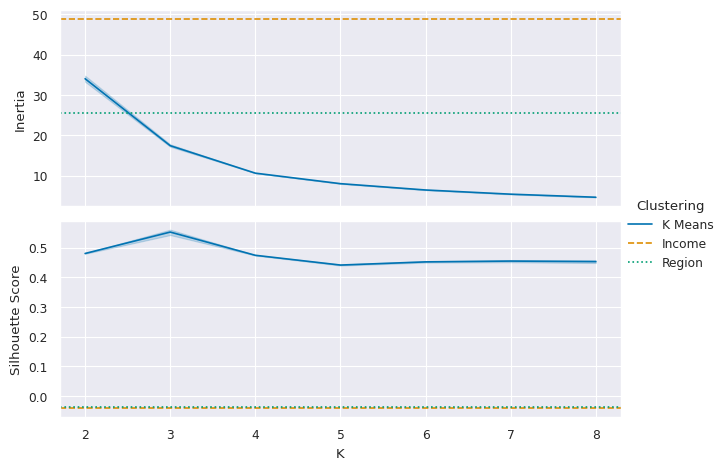

In [ ]:
fig, axes = plt.subplots(2, 1, sharex=True)
pal = sns.color_palette('colorblind', 3)

sns.lineplot(data=kdf, x='K', y='inertia', color=pal[0], linestyle='solid', ax=axes.flat[0])
axes.flat[0].axhline(y = clus_scores['Income']['Inertia'], color=pal[1], linestyle = 'dashed')
axes.flat[0].axhline(y = clus_scores['Region']['Inertia'], color=pal[2], linestyle = 'dotted')
axes.flat[0].set_xlabel('K')
axes.flat[0].set_ylabel('Inertia')

sns.lineplot(data=sdf, x='K', y='silhouette', color=pal[0], linestyle='solid', label='K Means', ax=axes.flat[1])
axes.flat[1].axhline(y = clus_scores['Income']['Silhouette'], color=pal[1], linestyle = 'dashed', label='Income')
axes.flat[1].axhline(y = clus_scores['Region']['Silhouette'], color=pal[2], linestyle = 'dotted', label='Region')
axes.flat[1].set_xlabel('K')
axes.flat[1].set_ylabel('Silhouette Score')
axes.flat[1].legend([],[], frameon=False)

fig.legend(title='Clustering', loc='center left', frameon=False,
           bbox_to_anchor=(0.98, 0.5), borderaxespad=0);
fig.tight_layout()
plt.show()

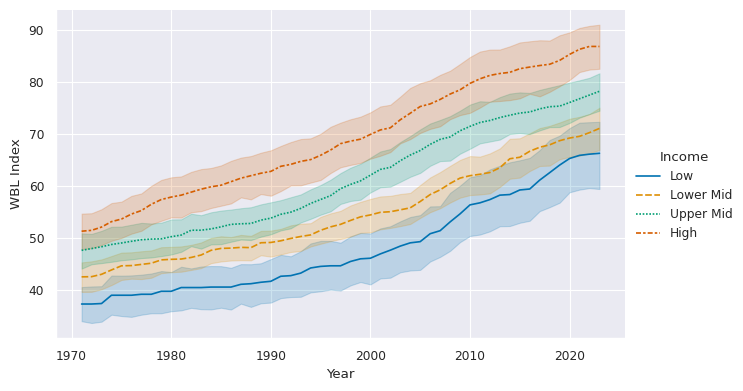

In [ ]:
g = sns.relplot(
  data=df2,
  x='Report Year', y='WBL INDEX',
  hue='Income Group', hue_order=['Low', 'Lower Mid', 'Upper Mid', 'High'],
  style='Income Group', style_order=['Low', 'Lower Mid', 'Upper Mid', 'High'],
  kind='line', height=4, aspect=1.618,
)
g.set_axis_labels(x_var='Year', y_var='WBL Index')
g.legend.set_title('Income');

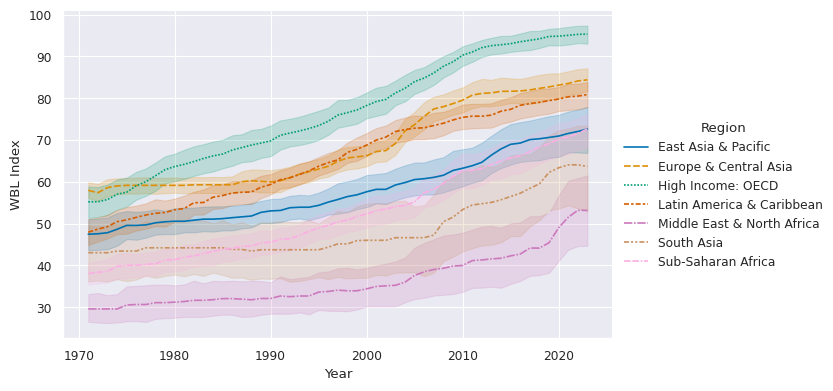

In [ ]:
order = [
  'East Asia & Pacific',
  'Europe & Central Asia',
  'High Income: OECD',
  'Latin America & Caribbean',
  'Middle East & North Africa',
  'South Asia',
  'Sub-Saharan Africa',
]

g = sns.relplot(
  data=df2,
  x='Report Year', y='WBL INDEX',
  hue='Region', hue_order=order,
  style='Region', style_order=order,
  kind='line', height=4, aspect=1.618,
)
g.set_axis_labels(x_var='Year', y_var='WBL Index');

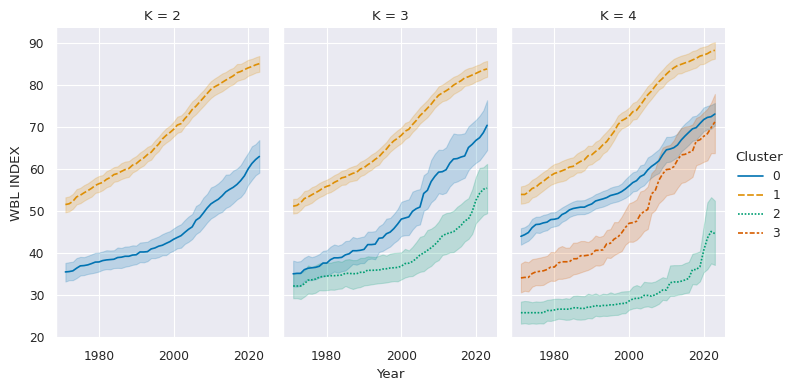

In [ ]:
value_vars = ['Cluster_2', 'Cluster_3', 'Cluster_4',]
id_vars = [c for c in df2 if c not in value_vars]
df2m = df2.melt(
  id_vars=id_vars, value_vars=value_vars,
  var_name='K', value_name='Cluster',
)
df2m['K'] = df2m['K'].str[-1].apply(int)
df2m['Cluster'] = df2m['Cluster'].apply(str)

g = sns.relplot(
  data=df2m, col='K',
  x='Report Year', y='WBL INDEX',
  hue='Cluster', style='Cluster',
  kind='line', height=4, aspect=0.618,
)
xlabs = ['', 'Year', '']
for i in range(3):
  g.axes[0, i].set_xlabel(xlabs[i])
plt.show()

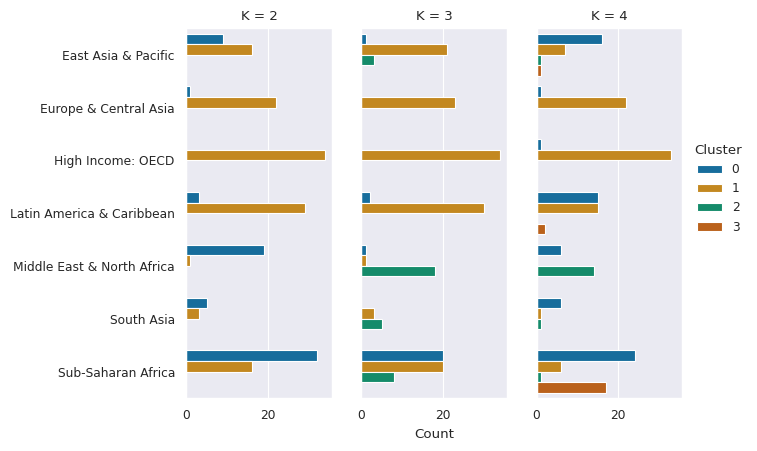

In [ ]:
parts = {
    k: df2m.query('K == @k').groupby(['Economy', 'K'])[['Cluster', 'Region']].agg(pd.Series.mode).reset_index() for k in range(2, 5)
}

fig, axes = plt.subplots(1, 3, sharex=True)

xlabs = ['', 'Count', '']
ylabs = ['', '', '']
order = [
  'East Asia & Pacific',
  'Europe & Central Asia',
  'High Income: OECD',
  'Latin America & Caribbean',
  'Middle East & North Africa',
  'South Asia',
  'Sub-Saharan Africa',
]
for k, ax in zip(range(2, 5), axes.flat):
  g = sns.countplot(
    data=parts[k], y='Region', order=order,
    hue='Cluster', hue_order=[f'{i}' for i in range(4)],
    ax=ax
  )
  if k > 2:
    g.set(yticklabels=[])
  ax.set_title(f'K = {k}')
  ax.set_xlabel(xlabs[k-2])
  ax.set_ylabel(ylabs[k-2])
  if k < 4:
    ax.legend([],[], frameon=False)
  else:
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 0.7),
               loc='upper left', borderaxespad=0, frameon=False)

plt.show()

In [ ]:
incomes = df2['Income Group'].unique()
results = {}

for var in agg_vars:
  groups = [df2.loc[df2['Income Group'] == i, var] for i in incomes]
  results[var] = stats.f_oneway(*groups)

results

{'WBL INDEX': F_onewayResult(statistic=617.3848268048356, pvalue=0.0),
 'MOBILITY': F_onewayResult(statistic=175.22461654781983, pvalue=9.642338217771108e-111),
 'WORKPLACE': F_onewayResult(statistic=122.24011871456294, pvalue=9.151779492674683e-78),
 'PAY': F_onewayResult(statistic=241.5102383770163, pvalue=2.4659017247731336e-151),
 'MARRIAGE': F_onewayResult(statistic=396.3262266317247, pvalue=2.381395570764549e-243),
 'PARENTHOOD': F_onewayResult(statistic=371.8451378338936, pvalue=4.725238677964319e-229),
 'ENTREPRENEURSHIP': F_onewayResult(statistic=234.346424926886, pvalue=5.542216101770302e-147),
 'ASSETS': F_onewayResult(statistic=708.2370264312666, pvalue=0.0),
 'PENSION': F_onewayResult(statistic=144.94008130389372, pvalue=5.961574344564575e-92)}

In [ ]:
regs = df2['Region'].unique()
reg_results = {}

for var in agg_vars:
  groups = [df2.loc[df2['Region'] == r, var] for r in regs]
  reg_results[var] = stats.f_oneway(*groups)

reg_results

{'WBL INDEX': F_onewayResult(statistic=1184.6900660463907, pvalue=0.0),
 'MOBILITY': F_onewayResult(statistic=1125.837652125787, pvalue=0.0),
 'WORKPLACE': F_onewayResult(statistic=204.62837348186997, pvalue=4.1827545488647576e-247),
 'PAY': F_onewayResult(statistic=338.5767217683321, pvalue=0.0),
 'MARRIAGE': F_onewayResult(statistic=1256.8571374781313, pvalue=0.0),
 'PARENTHOOD': F_onewayResult(statistic=1059.8676968931854, pvalue=0.0),
 'ENTREPRENEURSHIP': F_onewayResult(statistic=299.35907004550495, pvalue=0.0),
 'ASSETS': F_onewayResult(statistic=1456.3681899810197, pvalue=0.0),
 'PENSION': F_onewayResult(statistic=280.31677701189864, pvalue=0.0)}

In [ ]:
cl_results = {}

for k in range(2, 5):
  k_name = f'K = {k}'
  cl_results[k_name] = {}
  dfk = df2m[df2m['K'] == k]
  clus = dfk['Cluster'].unique()

  for var in agg_vars:
    groups = [dfk.loc[dfk['Cluster'] == c, var] for c in clus]
    cl_results[k_name][var] = stats.f_oneway(*groups)

cl_results

{'K = 2': {'WBL INDEX': F_onewayResult(statistic=5487.444693095104, pvalue=0.0),
  'MOBILITY': F_onewayResult(statistic=3097.374779308017, pvalue=0.0),
  'WORKPLACE': F_onewayResult(statistic=1147.8926407751105, pvalue=2.2262888248087185e-238),
  'PAY': F_onewayResult(statistic=773.5727728917536, pvalue=4.312337683751396e-164),
  'MARRIAGE': F_onewayResult(statistic=7049.021643835028, pvalue=0.0),
  'PARENTHOOD': F_onewayResult(statistic=1063.907593090783, pvalue=6.232435670545775e-222),
  'ENTREPRENEURSHIP': F_onewayResult(statistic=769.5920934428484, pvalue=2.745457882865848e-163),
  'ASSETS': F_onewayResult(statistic=11811.676910799928, pvalue=0.0),
  'PENSION': F_onewayResult(statistic=14.837078420025696, pvalue=0.00011793506474472224)},
 'K = 3': {'WBL INDEX': F_onewayResult(statistic=2937.813663567912, pvalue=0.0),
  'MOBILITY': F_onewayResult(statistic=2695.1814618662984, pvalue=0.0),
  'WORKPLACE': F_onewayResult(statistic=632.6809045843435, pvalue=1.498310342988476e-259),
  'P

In [ ]:
lm_results = {}
for g in df2['Income Group'].unique():
  part_df = df2.query(f'`Income Group` == "{g}"')
  X = part_df[['Report Year']]
  y = part_df['WBL INDEX']
  reg = LinearRegression().fit(X, y)
  lm_results[g] = {
    'coef': reg.coef_,
    'inter': reg.intercept_,
    'year_100': (100 - reg.intercept_.item()) / reg.coef_.item(),
  }
  print(f'Income Group {g} will reach WBL Index 100 by Year {int(lm_results[g]["year_100"])}.')

Income Group Low will reach WBL Index 100 by Year 2089.
Income Group Upper Mid will reach WBL Index 100 by Year 2056.
Income Group Lower Mid will reach WBL Index 100 by Year 2079.
Income Group High will reach WBL Index 100 by Year 2040.


In [ ]:
lm_results = {}
for r in df2['Region'].unique():
  part_df = df2.query(f'Region == "{r}"')
  X = part_df[['Report Year']]
  y = part_df['WBL INDEX']
  reg = LinearRegression().fit(X, y)
  lm_results[r] = {
    'coef': reg.coef_,
    'inter': reg.intercept_,
    'year_100': (100 - reg.intercept_.item()) / reg.coef_.item(),
  }
  print(f'Region {r} will reach WBL Index 100 by Year {int(lm_results[r]["year_100"])}.')

Region South Asia will reach WBL Index 100 by Year 2134.
Region Europe & Central Asia will reach WBL Index 100 by Year 2049.
Region Middle East & North Africa will reach WBL Index 100 by Year 2167.
Region Sub-Saharan Africa will reach WBL Index 100 by Year 2067.
Region Latin America & Caribbean will reach WBL Index 100 by Year 2047.
Region High Income: OECD will reach WBL Index 100 by Year 2024.
Region East Asia & Pacific will reach WBL Index 100 by Year 2083.


In [ ]:
lm_results = {}
for k in range(2, 5):
  k_name = f'K = {k}'
  lm_results[k_name] = {}
  dfk = df2m.query(f'K == {k}')
  clus = dfk['Cluster'].unique()
  print(f'K = {k}')
  for c in clus:
    part_df = dfk.query(f'Cluster == "{c}"')
    X = part_df[['Report Year']]
    y = part_df['WBL INDEX']
    reg = LinearRegression().fit(X, y)
    lm_results[k_name][c] = {
      'coef': reg.coef_,
      'inter': reg.intercept_,
      'year_100': (100 - reg.intercept_.item()) / reg.coef_.item(),
    }
    print(f'Cluster {c} will reach WBL Index 100 by Year {int(lm_results[k_name][c]["year_100"])}.')

K = 2
Cluster 0 will reach WBL Index 100 by Year 2107.
Cluster 1 will reach WBL Index 100 by Year 2042.
K = 3
Cluster 2 will reach WBL Index 100 by Year 2160.
Cluster 1 will reach WBL Index 100 by Year 2045.
Cluster 0 will reach WBL Index 100 by Year 2071.
K = 4
Cluster 2 will reach WBL Index 100 by Year 2255.
Cluster 1 will reach WBL Index 100 by Year 2036.
Cluster 0 will reach WBL Index 100 by Year 2075.
Cluster 3 will reach WBL Index 100 by Year 2067.


In [ ]:
sheets = [
  'BUSINESS OWNERS',
  'BUSINESS DIRECTORS',
  'SOLE PROPRIETORS',
]
sheet_d = {}

for s in sheets:
  sheet_d[s] = (
    pd
    .read_excel(j_path, sheet_name=s)
    .replace({'Turkey': 'Türkiye', 'China*': 'China'})
    .iloc[:, :4]
    .dropna()
  )
  sheet_d[s].columns = ['Economy', 'Year', 'Female', 'Male']

bdf = pd.merge(sheet_d['BUSINESS OWNERS'], sheet_d['BUSINESS DIRECTORS'], on=['Economy', 'Year'], suffixes=['_Own', '_Dir'])
bdf = pd.merge(bdf, sheet_d['SOLE PROPRIETORS'], on=['Economy', 'Year'])
bdf = bdf.rename(columns={'Female': 'Female_Sole', 'Male': 'Male_Sole'})



bdf = pd.merge(bdf, groups_df, on=['Economy'])

value_vars = [f'Cluster_{i}' for i in range(2, 6)]
id_vars = [c for c in bdf.columns if c not in value_vars]

bdf_melt = bdf.melt(
  id_vars=id_vars, value_vars=value_vars,
  var_name='K', value_name='Cluster',
)
bdf_melt['K'] = bdf_melt['K'].str[-1]
bdf_melt['Owners'] = bdf_melt['Female_Own'] / (bdf_melt['Female_Own'] + bdf_melt['Male_Own'])
bdf_melt['Directors'] = bdf_melt['Female_Dir'] / (bdf_melt['Female_Dir'] + bdf_melt['Male_Dir'])
bdf_melt['Sole Proprietors'] = bdf_melt['Female_Sole'] / (bdf_melt['Female_Sole'] + bdf_melt['Male_Sole'])

value_vars = ['Owners', 'Directors', 'Sole Proprietors']
id_vars = [c for c in bdf_melt.columns if c not in value_vars]

bdf_melt = bdf_melt.melt(
  id_vars=id_vars, value_vars=value_vars,
  var_name='Role', value_name='Female Proportion',
)

bdf_melt['Cluster'] = bdf_melt['Cluster'].apply(str)

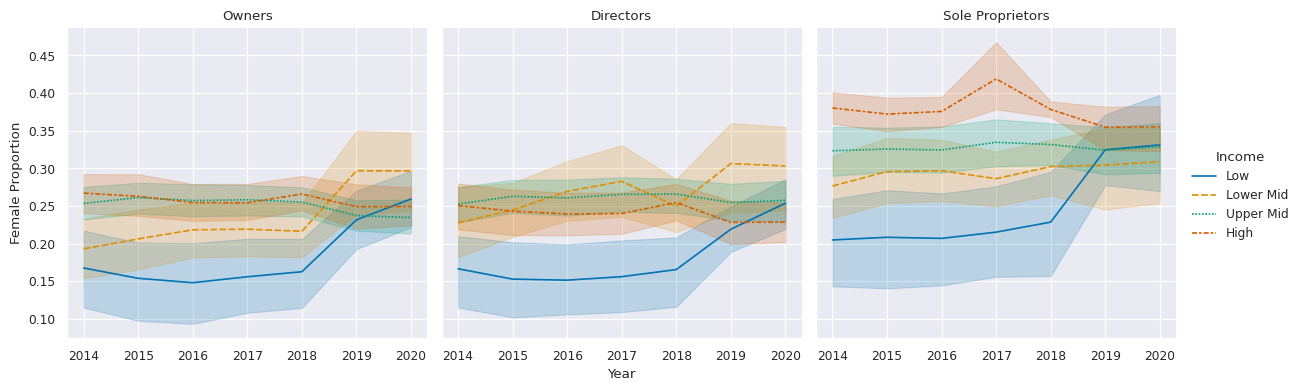

In [ ]:
g = sns.relplot(
  data=bdf_melt, col='Role',
  x='Year', y='Female Proportion',
  hue='Income', hue_order=['Low', 'Lower Mid', 'Upper Mid', 'High'],
  style='Income', style_order=['Low', 'Lower Mid', 'Upper Mid', 'High'],
  kind='line', height=4, aspect=1,
)
g.set_titles(col_template='{col_name}')
xlabs = ['', 'Year', '']
for i in range(3):
  g.axes[0, i].set_xlabel(xlabs[i])
plt.show()

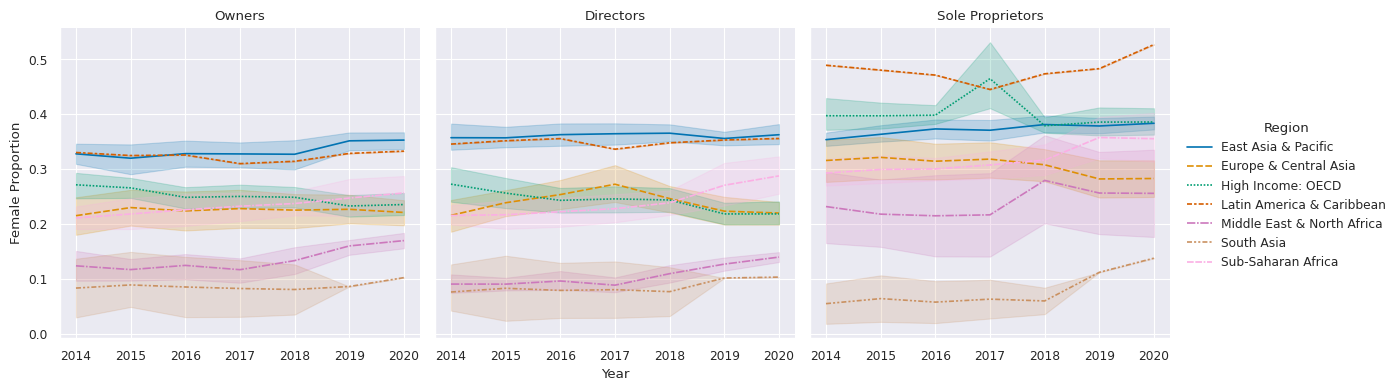

In [ ]:
order = [
  'East Asia & Pacific',
  'Europe & Central Asia',
  'High Income: OECD',
  'Latin America & Caribbean',
  'Middle East & North Africa',
  'South Asia',
  'Sub-Saharan Africa',
]

g = sns.relplot(
  data=bdf_melt, col='Role',
  x='Year', y='Female Proportion',
  hue='Region', hue_order=order,
  style='Region', style_order=order,
  kind='line', height=4, aspect=1,
)
g.set_titles(col_template='{col_name}')
xlabs = ['', 'Year', '']
for i in range(3):
  g.axes[0, i].set_xlabel(xlabs[i])
plt.show()

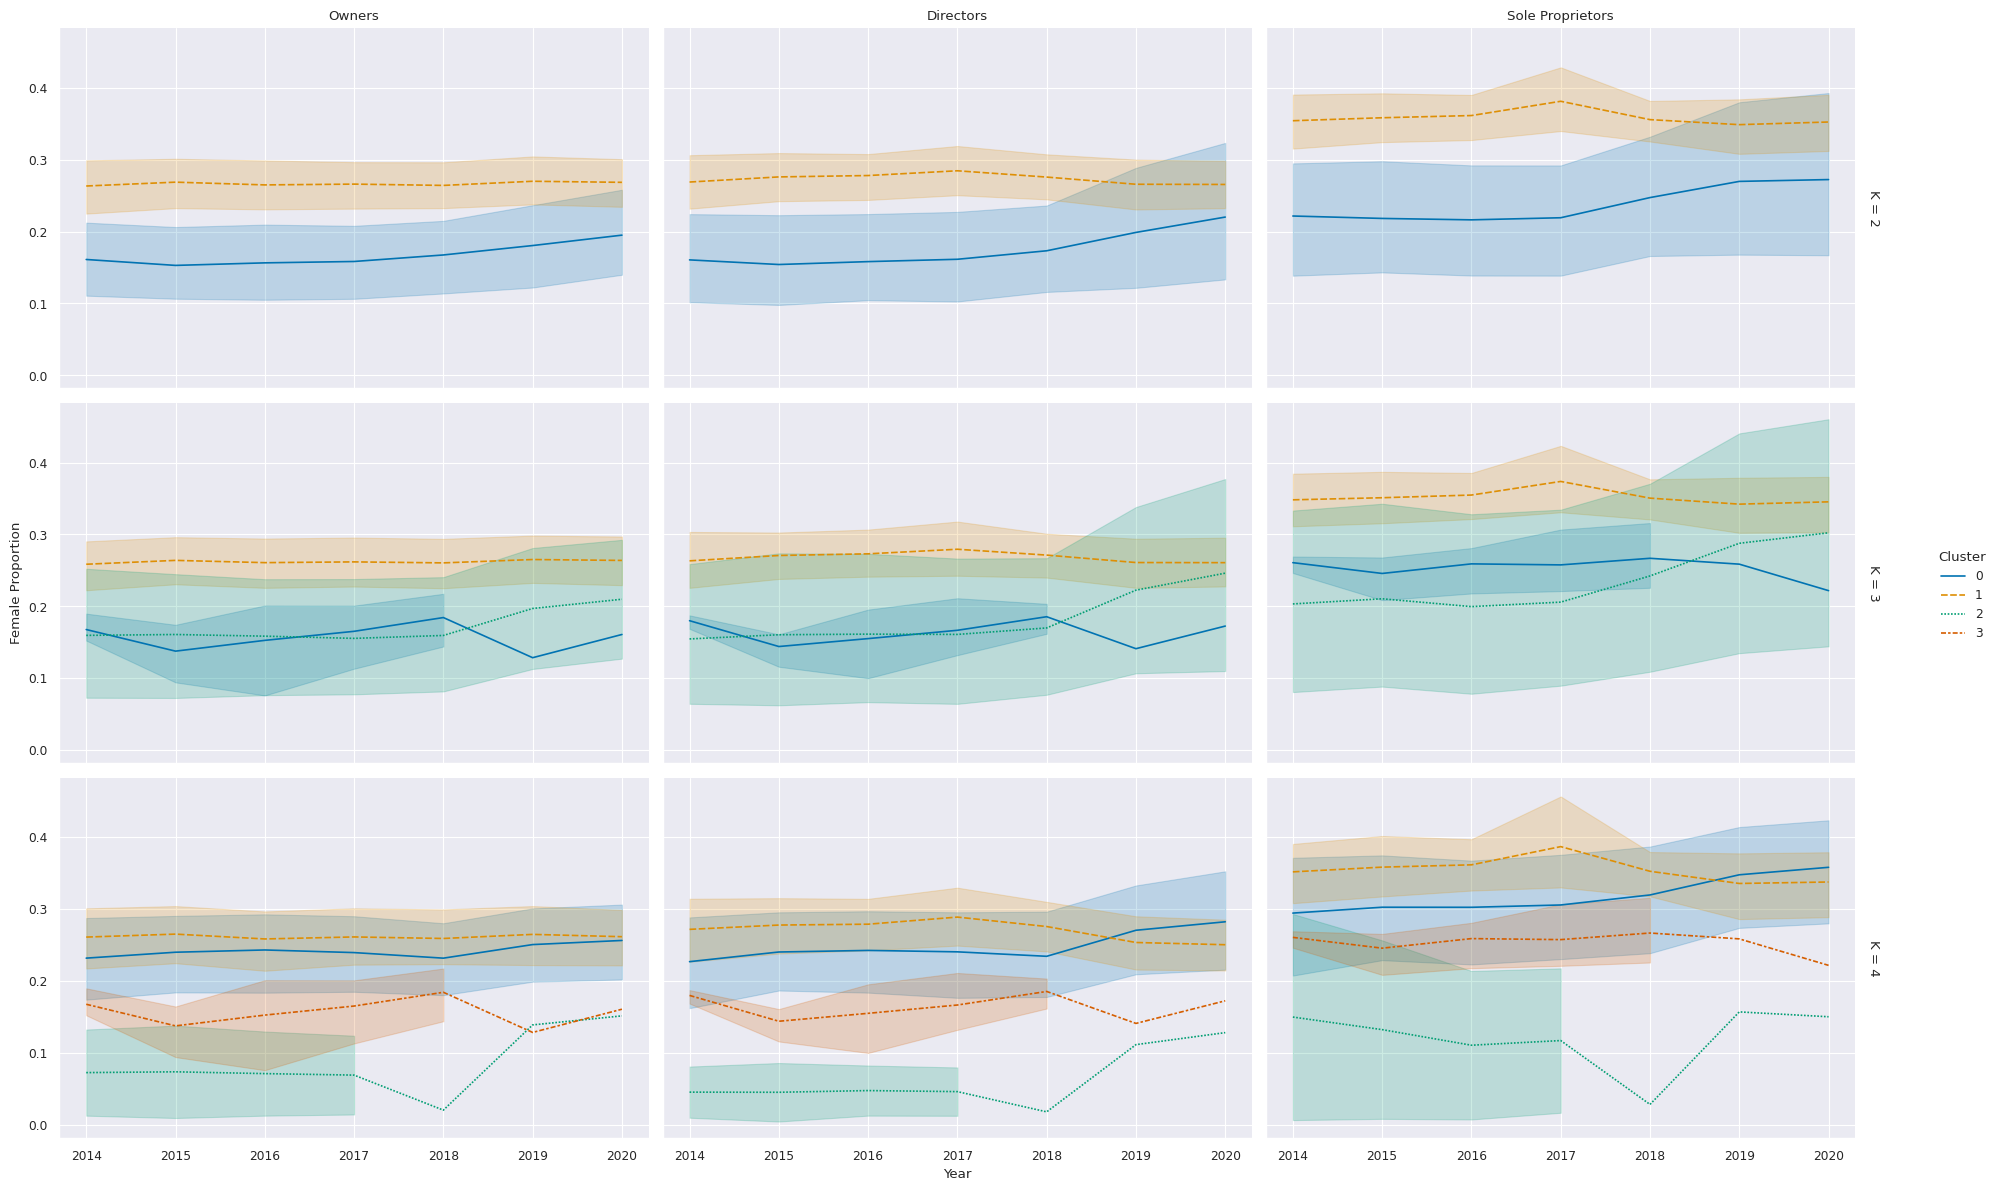

In [ ]:
g = sns.relplot(
  data=bdf_melt[bdf_melt['K'].isin(['2', '3', '4'])],
  col='Role', row='K',
  x='Year', y='Female Proportion',
  hue='Cluster', style='Cluster',
  kind='line', height=4, aspect=1.618,
  facet_kws={
    'sharey': True,
    'sharex': True,
    'margin_titles': True,
  },
)
g.set_titles(col_template='{col_name}')
xlabs = ['', 'Year', '']
ylabs = ['', 'Female Proportion', '']
for i in range(3):
  g.axes[2, i].set_xlabel(xlabs[i])
  g.axes[i, 0].set_ylabel(ylabs[i])
plt.show()